In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import os
from env import get_db_url
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import wrangle_zillow
import scipy.stats as stats
alpha = .05
from sklearn.cluster import KMeans

### Acquire

In [2]:
df = wrangle_zillow.get_zillow_data()

In [3]:
df.shape

(52441, 68)

### Prepare
- Preparation steps include:
    - Removing columns and rows with more than 30% data missing.
    - Removed additional rows with null values.
    - Removed outliers (IQR and k =1.5)
    - Converted data types to integers
    - Labeled counties by name
    - Removed erroneous or duplicated columns
    - Created age, month_of_sale, taxvalue_per_sqft

- Feature ranges of homes:
- Data dictionary

In [4]:
df = wrangle_zillow.prepare_zillow_data(df)

In [5]:
df.shape

(33660, 18)

In [6]:
df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror,transactiondate,propertylandusedesc,age,taxvalue_per_sqft,month_of_sale
0,3.5,4,3100,Orange,33634931,-117869207,4506,53571,96978,1998,1023282,11013,0.025595,2017-01-01,Single Family Residential,19,330,1
2,2.0,3,1243,Orange,33886168,-117823170,8432,21412,97078,1962,564778,6488,0.005383,2017-01-01,Single Family Residential,55,454,1
5,1.0,2,738,Los_Angeles,34149214,-118239357,4214,45457,96325,1922,218552,2366,0.101723,2017-01-01,Single Family Residential,95,296,1
7,3.0,4,2540,Los_Angeles,34434971,-118464390,10384,54311,96374,1999,430108,6103,0.005963,2017-01-02,Single Family Residential,18,169,1
9,2.5,3,1371,Ventura,34238229,-119170633,3445,13150,97107,2004,198054,2204,0.008669,2017-01-02,Single Family Residential,13,144,1


In [7]:
# split data
train, validate, test = wrangle_zillow.split_zillow_data(df)

In [8]:
train.shape, validate.shape, test.shape

((18849, 18), (8079, 18), (6732, 18))

### Explore

Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

Answer those questions through a mix of statistical tests and visualizations.

Bonus:

Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathroomcnt,33660.0,2.087715e+00,0.686865,1.000000e+00,2.000000e+00,2.000000e+00,2.500000e+00,4.000000e+00
bedroomcnt,33660.0,3.221628e+00,0.767260,2.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00
calculatedfinishedsquarefeet,33660.0,1.660689e+03,562.282346,4.800000e+02,1.242000e+03,1.552000e+03,1.983000e+03,3.522000e+03
latitude,33660.0,3.401917e+07,274278.706166,3.334425e+07,3.382422e+07,3.398879e+07,3.419368e+07,3.471836e+07
longitude,33660.0,-1.181808e+08,357826.205517,-1.194484e+08,-1.183726e+08,-1.181209e+08,-1.179262e+08,-1.175723e+08
lotsizesquarefeet,33660.0,6.629226e+03,2024.763938,1.350000e+03,5.429000e+03,6.500000e+03,7.670000e+03,1.243400e+04
regionidcity,33660.0,3.474437e+04,52429.771427,3.491000e+03,1.244700e+04,2.483200e+04,4.022700e+04,3.965560e+05
regionidzip,33660.0,9.660146e+04,1703.789228,9.598200e+04,9.622100e+04,9.645100e+04,9.700600e+04,3.996750e+05
yearbuilt,33660.0,1.963157e+03,20.041119,1.914000e+03,1.951000e+03,1.960000e+03,1.977000e+03,2.012000e+03
taxvaluedollarcnt,33660.0,3.531255e+05,218856.903437,3.254000e+03,1.749902e+05,3.290260e+05,4.940000e+05,1.070530e+06


In [10]:
df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror,transactiondate,propertylandusedesc,age,taxvalue_per_sqft,month_of_sale
0,3.5,4,3100,Orange,33634931,-117869207,4506,53571,96978,1998,1023282,11013,0.025595,2017-01-01,Single Family Residential,19,330,1
2,2.0,3,1243,Orange,33886168,-117823170,8432,21412,97078,1962,564778,6488,0.005383,2017-01-01,Single Family Residential,55,454,1
5,1.0,2,738,Los_Angeles,34149214,-118239357,4214,45457,96325,1922,218552,2366,0.101723,2017-01-01,Single Family Residential,95,296,1
7,3.0,4,2540,Los_Angeles,34434971,-118464390,10384,54311,96374,1999,430108,6103,0.005963,2017-01-02,Single Family Residential,18,169,1
9,2.5,3,1371,Ventura,34238229,-119170633,3445,13150,97107,2004,198054,2204,0.008669,2017-01-02,Single Family Residential,13,144,1


In [11]:
#looking at the counts for each column
for column in df.columns:
    print(column)
    print(df[column].value_counts())
    print("-------------------------------")

bathroomcnt
2.0    16649
3.0     6401
1.0     6164
2.5     3115
1.5      547
4.0      511
3.5      273
Name: bathroomcnt, dtype: int64
-------------------------------
bedroomcnt
3    16956
4     9700
2     5416
5     1588
Name: bedroomcnt, dtype: int64
-------------------------------
calculatedfinishedsquarefeet
1120    106
1200     85
1570     69
1400     69
1080     68
       ... 
2869      1
562       1
3231      1
598       1
512       1
Name: calculatedfinishedsquarefeet, Length: 2715, dtype: int64
-------------------------------
fips
Los_Angeles    21173
Orange          9478
Ventura         3009
Name: fips, dtype: int64
-------------------------------
latitude
34712133    4
34229075    4
34163686    3
33770026    3
33914773    3
           ..
34022001    1
33883380    1
34233017    1
33973025    1
33937685    1
Name: latitude, Length: 32820, dtype: int64
-------------------------------
longitude
-117847000    5
-117849000    4
-117762000    4
-117768000    3
-118338656    3
     

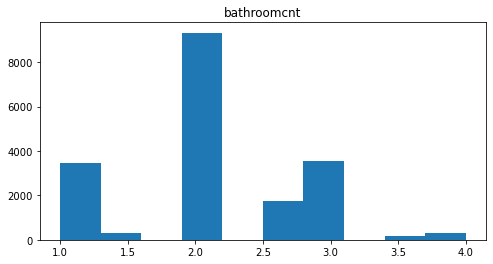

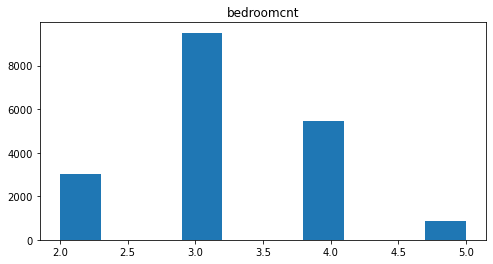

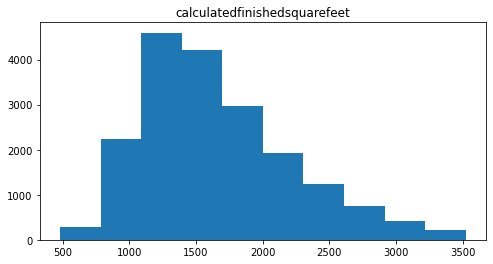

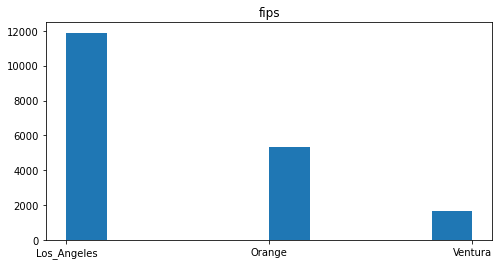

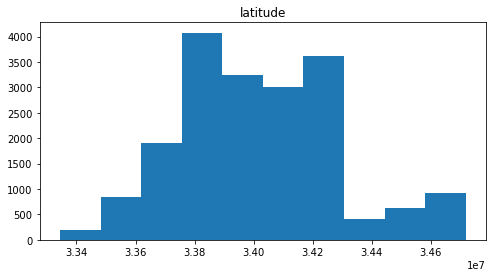

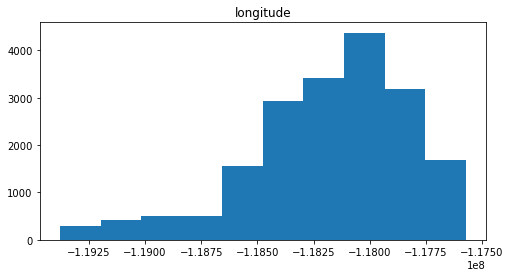

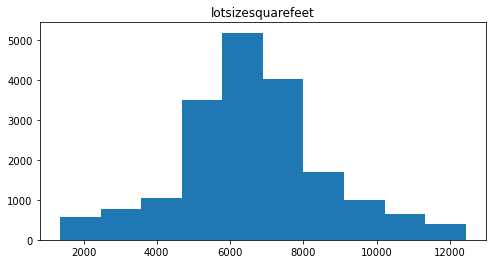

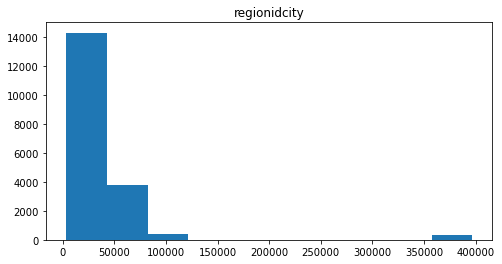

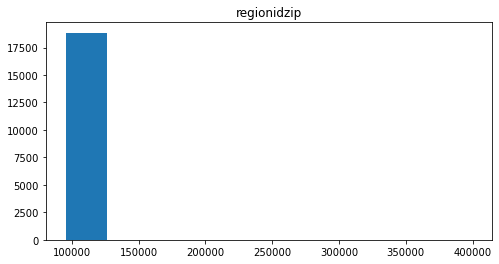

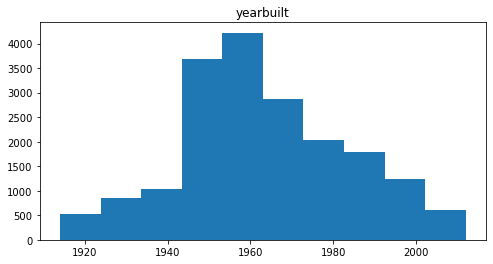

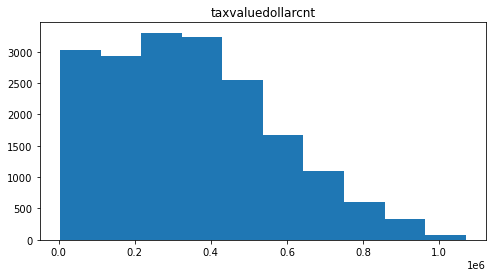

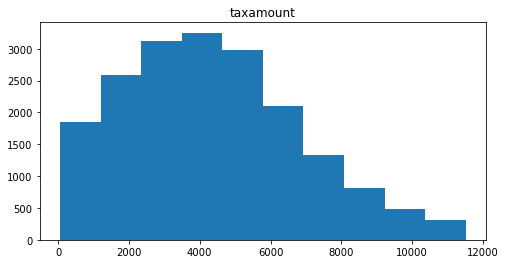

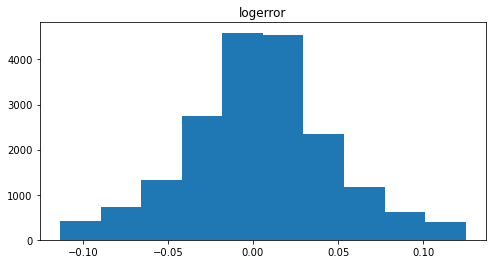

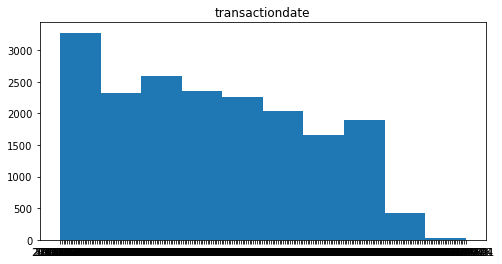

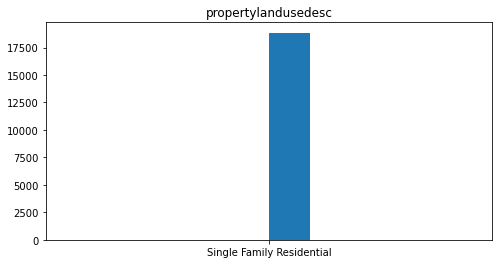

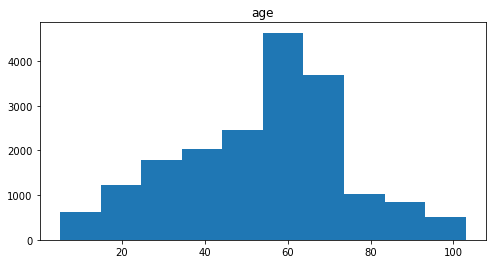

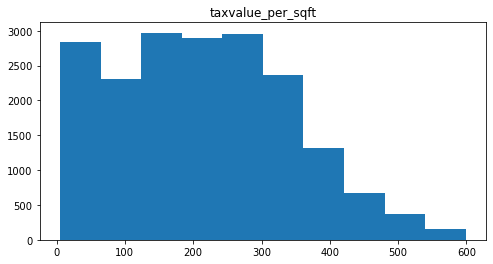

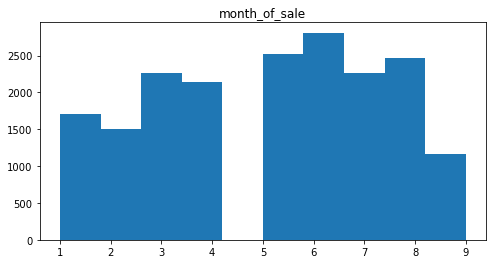

In [12]:
#create all the histograms:
for col in train.columns:
    plt.figure(figsize=(8,4))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

### Questions to ask:
   - Is log error dependent on county?
   - Are log error and tax value related?
   - Are log error and square feet related?
   - Are log error and tax value per square feet related?
   - Are log error and age related?
   - Are log error and latitude/longitude related?
    

### Log error and county

<AxesSubplot:title={'center':'Is log error dependent on County?'}, xlabel='fips', ylabel='logerror'>

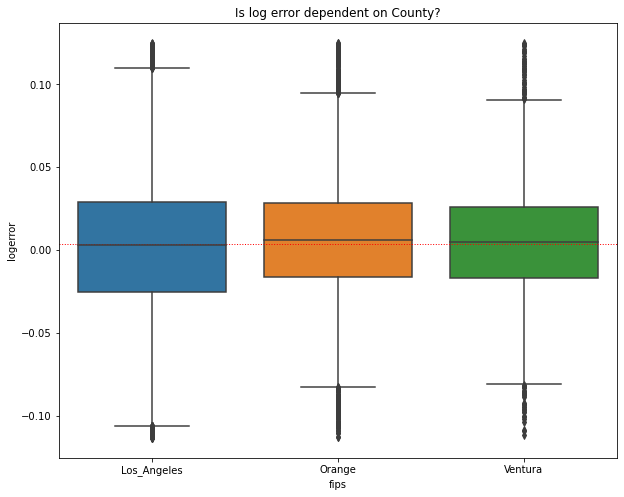

In [13]:
plt.figure(figsize=(10,8))
plt.title("Is log error dependent on County?")
plt.axhline(train.logerror.mean(),ls= ':', color = 'red', linewidth=1)
sns.boxplot(x=train.fips, y=train.logerror)

**Notes:**
- LA county's median value is more closely centered around zero, while Orange and Ventura counties have a higher median logerror.


Next step:
- Run statistical tests to determine if there is a difference in each county and the population mean.

- Null Hypothesis: The mean logerror of LA County is >= than the population mean.
- Alternative Hypothesis: The mean logerror of LA County is < than the population mean.

In [14]:
t, p = stats.ttest_1samp(train[train.fips=='Los_Angeles'].logerror.mean(), train.logerror.mean())

t, p/2
if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t > 0:
    print("We fail to reject the null hypothesis.")
else:
    print("We reject the null hypothesis.")


We reject the null hypothesis.


- Null Hypothesis: The mean logerror of Ventura County is <= than the population mean.
- Alternative Hypothesis: The mean logerror of Ventura County is > than the population mean.

In [15]:
t, p = stats.ttest_1samp(train[train.fips=='Ventura'].logerror.mean(), train.logerror.mean())
t, p/2
if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t < 0:
    print("We fail to reject the null hypothesis.")
else:
    print("We reject the null hypothesis.")

We reject the null hypothesis.


- Null Hypothesis: The mean logerror of Orange County is <= than the population mean.
- Alternative Hypothesis: The mean logerror of Orange County is > than the population mean.

In [16]:
t, p = stats.ttest_1samp(train[train.fips=='Orange'].logerror.mean(), train.logerror.mean())
t, p/2
if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t < 0:
    print("We fail to reject the null hypothesis.")
else:
    print("We reject the null hypothesis.")

We reject the null hypothesis.


In [17]:
df.logerror.mean(),train[train.fips=='Los_Angeles'].logerror.mean(), train[train.fips=='Ventura'].logerror.mean(), train[train.fips=='Orange'].logerror.mean()

(0.003940897366241479,
 0.0023822000199928656,
 0.0056996688918747014,
 0.0068176523245103)

**Notes: We can conclude, with statistical significance, that the means of the logerror of each county are not equal. LA County's logerror is less than the population, while Orange and Ventura counties' logerror means are greater than the population.**

### Log error and tax value

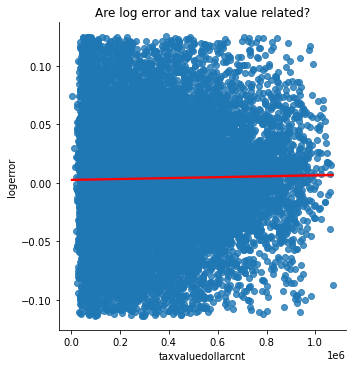

In [18]:
sns.lmplot(data=train, x='taxvaluedollarcnt',y='logerror',line_kws={'color':'red'})
plt.title("Are log error and tax value related?")
plt.show()

Slight increase in error as values increase.

<AxesSubplot:>

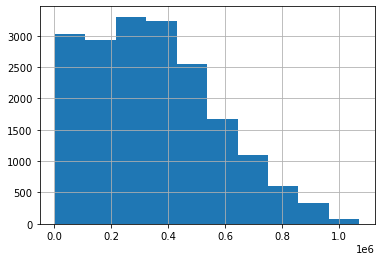

In [19]:
train.taxvaluedollarcnt.hist()

- Null Hypothesis: There is no linear correlation between tax value and log error.
- Alternative Hypothesis: There is a lonear correlation between tax value and log error.

In [20]:
# perform correlation testing on taxvaluedollar count and logerror
alpha=.05
corr, p = stats.spearmanr(train.taxvaluedollarcnt, train.logerror)
p < alpha, corr, p

(True, 0.01500189594050002, 0.03943540885960506)

**Reject the null hypothesis.**
There is a very weak positive correlation.

In [21]:
corr = pd.DataFrame(train.corr(method='spearman'))
corr

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror,age,taxvalue_per_sqft,month_of_sale
bathroomcnt,1.000000,0.553771,0.787263,-0.028695,0.104456,0.118753,0.002322,0.278291,0.606400,0.361314,0.364331,0.066753,-0.606400,-0.030394,0.019287
bedroomcnt,0.553771,1.000000,0.601850,0.007584,0.056120,0.213064,0.011457,0.220009,0.394019,0.189390,0.198042,0.036481,-0.394019,-0.117292,0.008053
calculatedfinishedsquarefeet,0.787263,0.601850,1.000000,-0.042847,0.087094,0.251690,-0.000329,0.241450,0.529788,0.392402,0.394698,0.078448,-0.529788,-0.097513,0.015384
latitude,-0.028695,0.007584,-0.042847,1.000000,-0.652440,0.322287,-0.167135,0.124715,-0.003788,-0.170227,-0.100933,-0.032425,0.003788,-0.159670,-0.003578
longitude,0.104456,0.056120,0.087094,-0.652440,1.000000,-0.097501,0.092136,0.267727,0.215561,0.057886,0.032319,0.018375,-0.215561,0.015707,-0.011693
lotsizesquarefeet,0.118753,0.213064,0.251690,0.322287,-0.097501,1.000000,-0.074265,0.168333,0.003527,-0.002830,0.014233,-0.012326,-0.003527,-0.131936,0.006577
regionidcity,0.002322,0.011457,-0.000329,-0.167135,0.092136,-0.074265,1.000000,0.014022,0.016669,0.065332,0.061209,0.011890,-0.016669,0.068338,0.001224
regionidzip,0.278291,0.220009,0.241450,0.124715,0.267727,0.168333,0.014022,1.000000,0.555653,0.051237,0.047682,0.024668,-0.555653,-0.075931,0.000324
yearbuilt,0.606400,0.394019,0.529788,-0.003788,0.215561,0.003527,0.016669,0.555653,1.000000,0.259124,0.267570,0.044269,-1.000000,-0.011868,0.018324
taxvaluedollarcnt,0.361314,0.189390,0.392402,-0.170227,0.057886,-0.002830,0.065332,0.051237,0.259124,1.000000,0.971897,0.015002,-0.259124,0.853820,0.033550


In [22]:
corr.logerror.sort_values(ascending=False)

logerror                        1.000000
calculatedfinishedsquarefeet    0.078448
bathroomcnt                     0.066753
yearbuilt                       0.044269
bedroomcnt                      0.036481
month_of_sale                   0.028788
regionidzip                     0.024668
longitude                       0.018375
taxvaluedollarcnt               0.015002
regionidcity                    0.011890
taxamount                       0.007004
lotsizesquarefeet              -0.012326
taxvalue_per_sqft              -0.026687
latitude                       -0.032425
age                            -0.044269
Name: logerror, dtype: float64

In [23]:
corr_p = pd.DataFrame(train.corr(method='pearson'))
corr_p

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror,age,taxvalue_per_sqft,month_of_sale
bathroomcnt,1.000000,0.563657,0.768436,0.010551,0.042321,0.137560,-0.068949,0.049177,0.566570,0.368086,0.371649,0.064624,-0.566570,-0.065079,0.018799
bedroomcnt,0.563657,1.000000,0.595143,0.029016,0.004397,0.215503,-0.062130,0.037230,0.359614,0.199706,0.205810,0.039748,-0.359614,-0.140536,0.006510
calculatedfinishedsquarefeet,0.768436,0.595143,1.000000,-0.028633,0.044961,0.261107,-0.062023,0.043864,0.510558,0.436508,0.435789,0.080020,-0.510558,-0.118982,0.015729
latitude,0.010551,0.029016,-0.028633,1.000000,-0.544904,0.301201,0.001858,0.023626,0.091502,-0.219321,-0.130289,-0.034330,-0.091502,-0.200486,-0.004004
longitude,0.042321,0.004397,0.044961,-0.544904,1.000000,-0.117018,-0.016052,0.034636,0.092467,0.033726,0.019503,0.009725,-0.092467,0.001412,-0.014149
lotsizesquarefeet,0.137560,0.215503,0.261107,0.301201,-0.117018,1.000000,-0.027765,0.012298,-0.029342,0.015758,0.027722,-0.008554,0.029342,-0.129352,0.006109
regionidcity,-0.068949,-0.062130,-0.062023,0.001858,-0.016052,-0.027765,1.000000,-0.024863,-0.116713,0.002965,-0.005696,-0.005438,0.116713,0.043098,-0.015298
regionidzip,0.049177,0.037230,0.043864,0.023626,0.034636,0.012298,-0.024863,1.000000,0.100243,0.001624,-0.000943,0.010116,-0.100243,-0.025643,-0.000383
yearbuilt,0.566570,0.359614,0.510558,0.091502,0.092467,-0.029342,-0.116713,0.100243,1.000000,0.263959,0.282283,0.042010,-1.000000,-0.034968,0.016498
taxvaluedollarcnt,0.368086,0.199706,0.436508,-0.219321,0.033726,0.015758,0.002965,0.001624,0.263959,1.000000,0.966831,0.019924,-0.263959,0.797684,0.032130


In [24]:
corr_p.logerror.sort_values(ascending=False)

logerror                        1.000000
calculatedfinishedsquarefeet    0.080020
bathroomcnt                     0.064624
yearbuilt                       0.042010
bedroomcnt                      0.039748
taxvaluedollarcnt               0.019924
month_of_sale                   0.015712
taxamount                       0.012199
regionidzip                     0.010116
longitude                       0.009725
regionidcity                   -0.005438
lotsizesquarefeet              -0.008554
taxvalue_per_sqft              -0.026848
latitude                       -0.034330
age                            -0.042010
Name: logerror, dtype: float64

### Log error and square feet

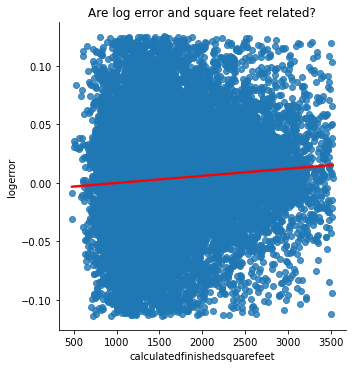

In [25]:
sns.lmplot(data=train, x='calculatedfinishedsquarefeet',y='logerror',line_kws={'color':'red'})
plt.title("Are log error and square feet related?")
plt.show()

<AxesSubplot:>

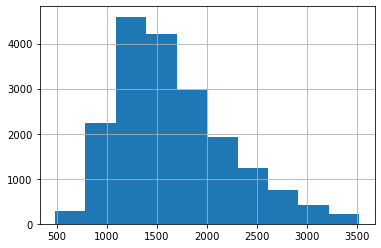

In [26]:
train.calculatedfinishedsquarefeet.hist()

In [27]:
# perform correlation testing on square feet and logerror
alpha=.05
corr, p = stats.spearmanr(train.calculatedfinishedsquarefeet, train.logerror)
p < alpha, corr, p

(True, 0.07844755708028653, 4.003996331739839e-27)

**Reject the null hypothesis.** While weak, this is the strongest correlation with log error.

### Log error and tax value per square feet

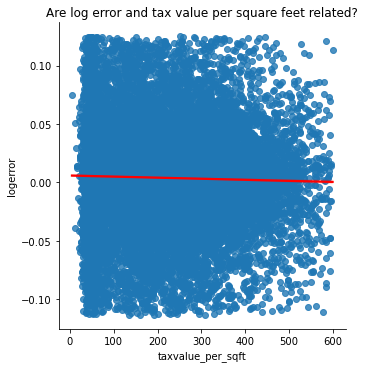

In [28]:
sns.lmplot(data=train, x='taxvalue_per_sqft',y='logerror',line_kws={'color':'red'})
plt.title("Are log error and tax value per square feet related?")
plt.show()

<AxesSubplot:>

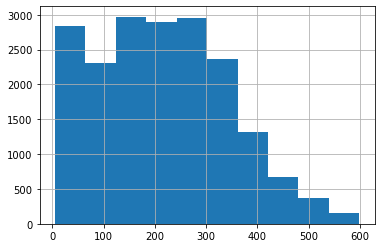

In [29]:
train.taxvalue_per_sqft.hist()

In [30]:
# perform correlation testing on taxvaluepersqft count and logerror
alpha=.05
corr, p = stats.spearmanr(train.taxvalue_per_sqft, train.logerror)
p < alpha, corr, p

(True, -0.026686864469764683, 0.0002480222445226254)

**Reject the null hypothesis.** There is a weak negative correlation.

### Log error and age

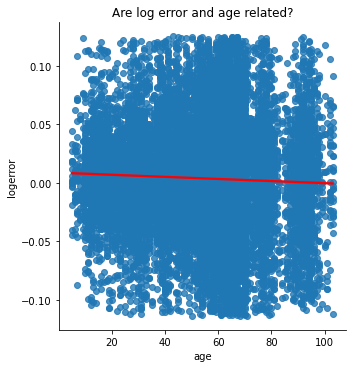

In [31]:
sns.lmplot(data=train, x='age',y='logerror',line_kws={'color':'red'})
plt.title("Are log error and age related?")
plt.show()

In [32]:
# perform correlation testing on taxvaluepersqft count and logerror
alpha=.05
corr, p = stats.pearsonr(train.age, train.logerror)
p < alpha, corr, p

(True, -0.04201049550159269, 7.933964116653264e-09)

**Reject the null hypothesis.** There is a weak negative correlation.

### Log error and latitude

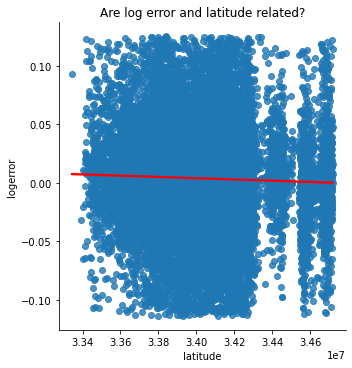

In [33]:
sns.lmplot(data=train, x='latitude',y='logerror',line_kws={'color':'red'})
plt.title("Are log error and latitude related?")
plt.show()

In [34]:
alpha=.05
corr, p = stats.pearsonr(train.latitude, train.logerror)
p < alpha, corr, p

(True, -0.03433005394750692, 2.425347258112339e-06)

**Reject the null hypothesis.** There is a weak negative correlation.

### Log error and longitude

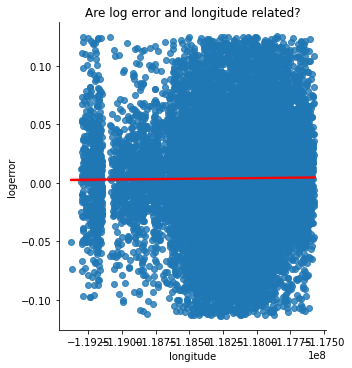

In [35]:
sns.lmplot(data=train, x='longitude',y='logerror',line_kws={'color':'red'})
plt.title("Are log error and longitude related?")
plt.show()

<AxesSubplot:>

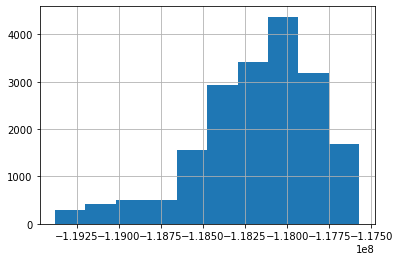

In [36]:
train.longitude.hist()

In [37]:
alpha=.05
corr, p = stats.spearmanr(train.longitude, train.logerror)
p < alpha, corr, p

(True, 0.01837548501702637, 0.011640919372846382)

**Reject the null hypothesis.** There is a weak positive correlation.

In [38]:
def calculate_pvalues_spearman(df):
    df = df.select_dtypes(include=['number'])
    pairs = pd.MultiIndex.from_product([df.columns, df.columns])
    pvalues = [stats.spearmanr(df[a], df[b])[1] for a, b in pairs]
    pvalues = pd.Series(pvalues, index=pairs).unstack().round(4)
    return pvalues

In [39]:
pvalues_s = calculate_pvalues_spearman(train)

In [40]:
pvalues_s.logerror < alpha

age                              True
bathroomcnt                      True
bedroomcnt                       True
calculatedfinishedsquarefeet     True
latitude                         True
logerror                         True
longitude                        True
lotsizesquarefeet               False
month_of_sale                    True
regionidcity                    False
regionidzip                      True
taxamount                       False
taxvalue_per_sqft                True
taxvaluedollarcnt                True
yearbuilt                        True
Name: logerror, dtype: bool

In [41]:
def calculate_pvalues_pearson(df):
    df = df.select_dtypes(include=['number'])
    pairs = pd.MultiIndex.from_product([df.columns, df.columns])
    pvalues = [stats.pearsonr(df[a], df[b])[1] for a, b in pairs]
    pvalues = pd.Series(pvalues, index=pairs).unstack().round(4)
    return pvalues

In [42]:
pvalues_p = calculate_pvalues_pearson(train)

In [43]:
pvalues_p.logerror < alpha

age                              True
bathroomcnt                      True
bedroomcnt                       True
calculatedfinishedsquarefeet     True
latitude                         True
logerror                         True
longitude                       False
lotsizesquarefeet               False
month_of_sale                    True
regionidcity                    False
regionidzip                     False
taxamount                       False
taxvalue_per_sqft                True
taxvaluedollarcnt                True
yearbuilt                        True
Name: logerror, dtype: bool

### Answers to questions:
- Log error differs by county.
- Log error increases as tax values increases.
- Log error decreases as the home of the age increases.
- **Log error increases as the size of the home increases.**
- Log error decreases as the tax value per square feet increases.
- There is a relationship between log error and latitude and longitude.

- The strongest correlation with log error is square feet, followed by age, latitude, tax value per square feet, longitude, and tax value.


Things to try next:
- Look into data after clustering

<Figure size 1440x2160 with 0 Axes>

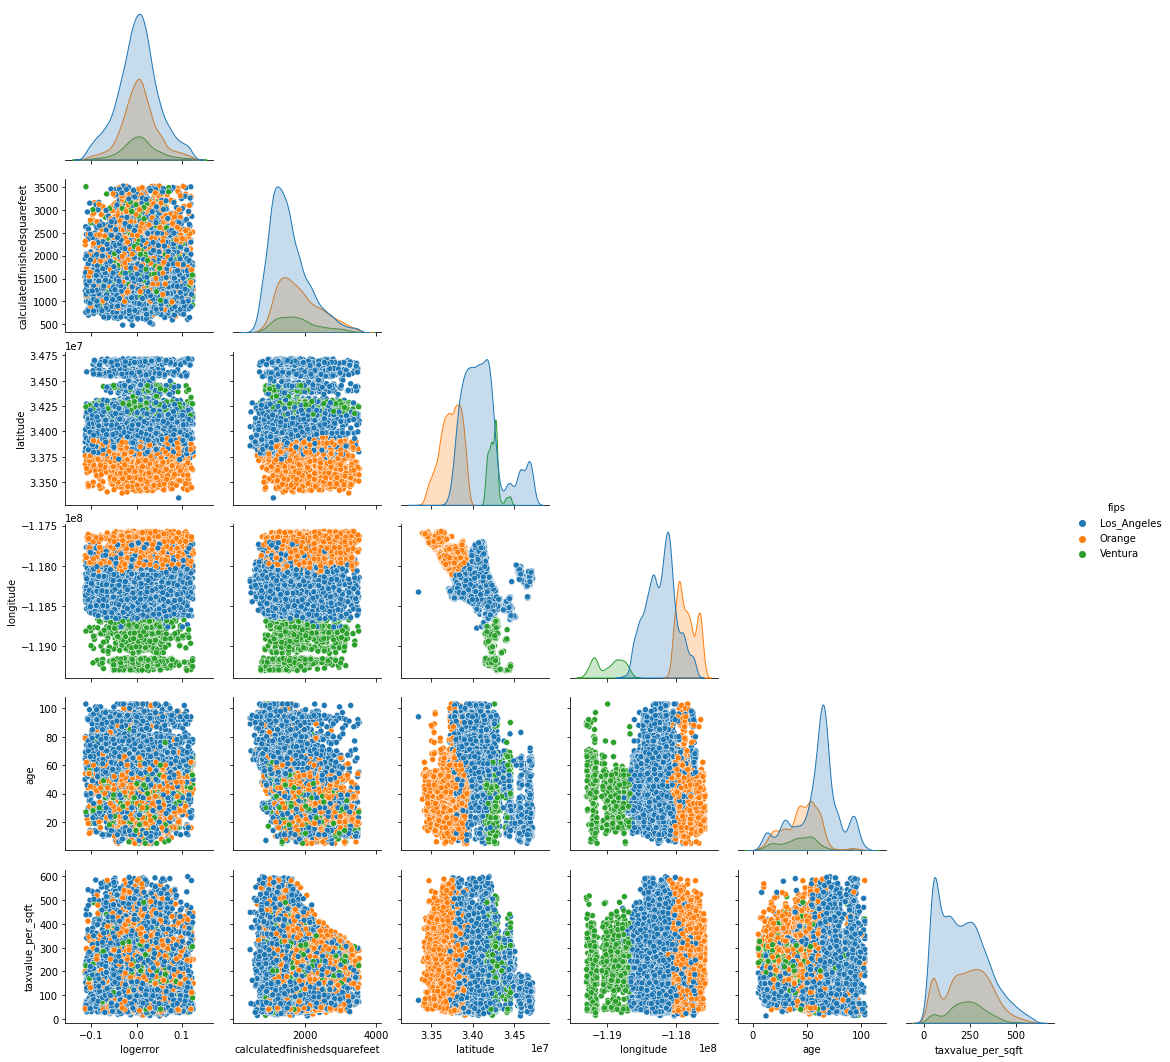

In [44]:
plt.figure(figsize = (20,30))
sns.pairplot(data=train.sample(10000), x_vars=['logerror', 'calculatedfinishedsquarefeet', 'latitude', 'longitude', 'age', 'taxvalue_per_sqft'],
                  y_vars=['logerror', 'calculatedfinishedsquarefeet', 'latitude', 'longitude', 'age', 'taxvalue_per_sqft'],
             hue = "fips", corner=True)


- **Latitude and longitude obviously make clear county clusters.**
- **Longitude clearly defined with logerror and taxvalue per square feet**

### Clustering

#### Clustering by latitude/longitude

In [45]:
train_scaled, validate_scaled, test_scaled = wrangle_zillow.scale_data(train,validate,test)

In [46]:
X_train = train_scaled[['latitude','longitude']]
X_validate = validate_scaled[['latitude','longitude']]
X_test = test_scaled[['latitude','longitude']]

In [52]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X_train)

kmeans.predict(X_train)
kmeans.predict(X_validate)
kmeans.predict(X_test)

array([2, 6, 2, ..., 5, 5, 1], dtype=int32)

In [53]:
train_scaled['clusters_by_lat_long'] = kmeans.predict(X_train)
validate_scaled['clusters_by_lat_long'] = kmeans.predict(X_validate)
test_scaled['clusters_by_lat_long'] = kmeans.predict(X_test)

Text(0.5, 1.0, 'K-Means Clusters')

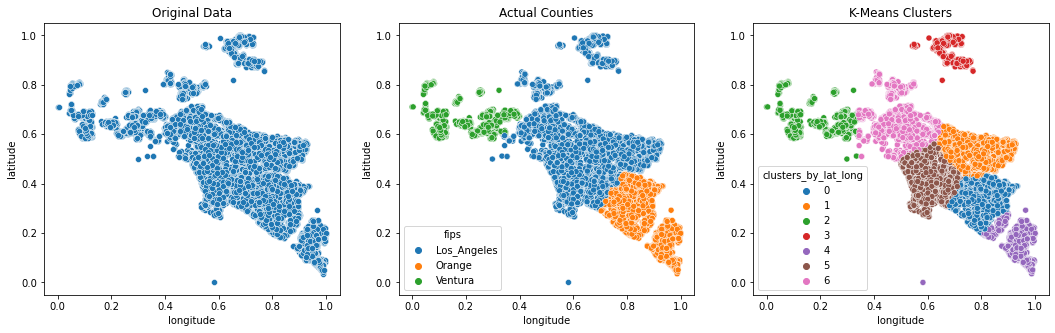

In [54]:
plt.figure(figsize=(18,5))
plt.subplot(131)
sns.scatterplot(data = train_scaled, x = 'longitude', y = 'latitude')
plt.title('Original Data')

plt.subplot(132)
sns.scatterplot(data = train_scaled, x = 'longitude', y = 'latitude', hue = 'fips')
plt.title('Actual Counties')

plt.subplot(133)
sns.scatterplot(data = train_scaled, x = 'longitude', y = 'latitude', hue = 'clusters_by_lat_long', palette = ('tab10'))
plt.title('K-Means Clusters')

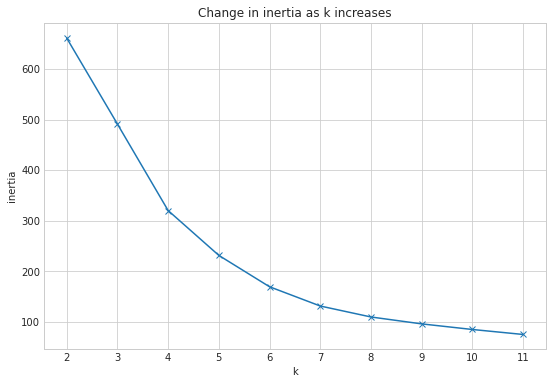

In [55]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_train).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

NameError: name 'X' is not defined

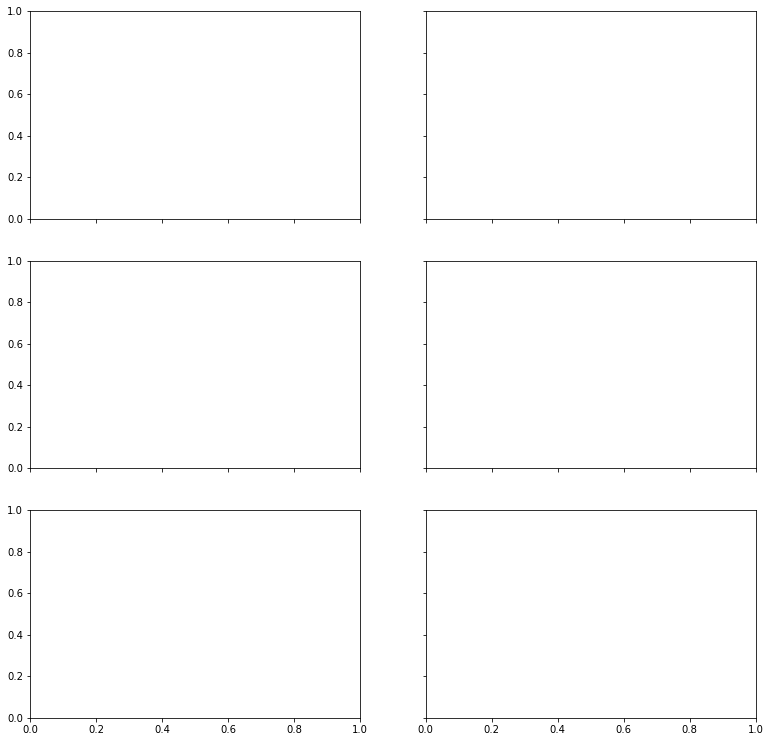

In [56]:
fig, axs = plt.subplots(3, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 8)):
    clusters = KMeans(k).fit(X).predict(X)
    ax.scatter(train.longitude, train.latitude, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='longitutde', ylabel='latitude')

#### Clustering by age and square feet

In [57]:
X_train = train_scaled[[ 'age','calculatedfinishedsquarefeet']]
X_validate = validate_scaled[[ 'age','calculatedfinishedsquarefeet']]
X_test = test_scaled[[ 'age','calculatedfinishedsquarefeet']]

In [66]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X_train)

kmeans.predict(X_train)
kmeans.predict(X_validate)
kmeans.predict(X_test)

array([3, 0, 5, ..., 0, 4, 0], dtype=int32)

In [67]:
train_scaled['clusters_scaled'] = kmeans.predict(X_train)
validate_scaled['clusters_scaled'] = kmeans.predict(X_validate)
test_scaled['clusters_scaled'] = kmeans.predict(X_test)

Text(0.5, 1.0, 'K-Means Clusters')

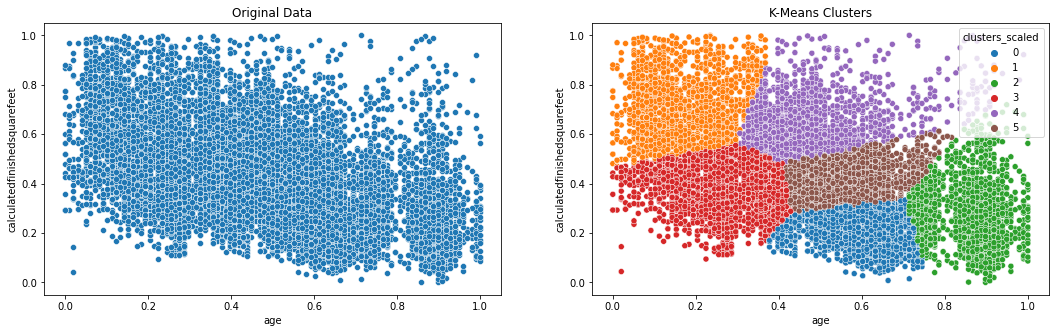

In [68]:
plt.figure(figsize=(18,5))
plt.subplot(121)
sns.scatterplot(data = train_scaled, x = 'age', y = 'calculatedfinishedsquarefeet')
plt.title('Original Data')

plt.subplot(122)
sns.scatterplot(data = train_scaled, x = 'age', y = 'calculatedfinishedsquarefeet', hue = 'clusters_scaled', palette = ('tab10'))
plt.title('K-Means Clusters')

In [69]:
validate_scaled.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror,transactiondate,propertylandusedesc,age,taxvalue_per_sqft,month_of_sale,clusters_by_lat_long,clusters_scaled
31531,0.333333,0.333333,0.223537,Los_Angeles,0.638121,0.463895,0.570345,12447,96354,0.448980,0.052990,842,-0.005874,2017-06-15,Single Family Residential,0.551020,0.077441,0.625,6,0
23825,0.666667,0.333333,0.382643,Los_Angeles,0.630944,0.447832,0.560321,12447,96341,0.408163,0.225870,3142,0.049696,2017-05-11,Single Family Residential,0.591837,0.240741,0.500,6,5
27072,0.666667,0.666667,0.674227,Ventura,0.700119,0.300623,0.396785,25974,97097,0.836735,0.379563,4478,-0.001256,2017-05-26,Single Family Residential,0.163265,0.262626,0.500,2,1
45177,0.000000,0.333333,0.381328,Los_Angeles,0.540503,0.741758,0.370056,51861,96478,0.377551,0.394120,6320,0.012967,2017-08-15,Single Family Residential,0.622449,0.425926,0.875,1,5
34319,0.666667,0.666667,0.619001,Los_Angeles,0.930462,0.652109,0.419812,40227,97329,0.918367,0.096042,2598,-0.027416,2017-06-27,Single Family Residential,0.081633,0.065657,0.625,3,1


Text(0.5, 1.0, 'K-Means Clusters - validate')

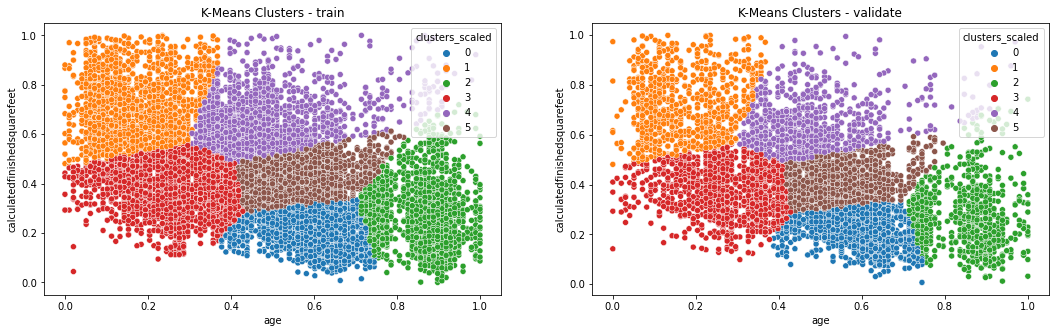

In [70]:
plt.figure(figsize=(18,5))
plt.subplot(121)
sns.scatterplot(data = train_scaled, x = 'age', y = 'calculatedfinishedsquarefeet', hue = 'clusters_scaled', palette = ('tab10'))
plt.title('K-Means Clusters - train')

plt.subplot(122)
sns.scatterplot(data = validate_scaled, x = 'age', y = 'calculatedfinishedsquarefeet', hue = 'clusters_scaled', palette = ('tab10'))
plt.title('K-Means Clusters - validate')

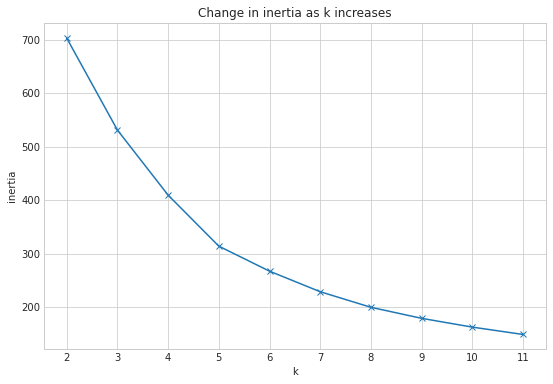

In [72]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_train).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

- **Notes: With locational clustering we can divide the 3 counties to 6 regions and may be better able to predict log error.**
- **

### View log error by clusters of age and square feet

In [78]:
train_scaled.clusters_scaled.value_counts()

0    5478
5    4112
3    3451
4    2010
2    1904
1    1894
Name: clusters_scaled, dtype: int64

<AxesSubplot:xlabel='clusters_scaled', ylabel='logerror'>

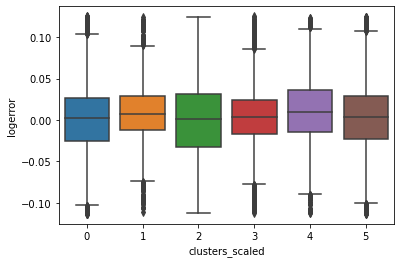

In [83]:
sns.boxplot(data=train_scaled,x='clusters_scaled',y='logerror')

In [88]:
train_scaled.groupby('clusters_scaled').logerror.mean()

clusters_scaled
0    0.001240
1    0.008131
2   -0.000005
3    0.004261
4    0.010884
5    0.003688
Name: logerror, dtype: float64

### View log error by clusters of latitude and longitude

In [76]:
train_scaled.clusters_by_lat_long.value_counts()

0    4219
5    3627
6    3486
1    3083
4    1747
2    1363
3    1324
Name: clusters_by_lat_long, dtype: int64

<AxesSubplot:xlabel='clusters_by_lat_long', ylabel='logerror'>

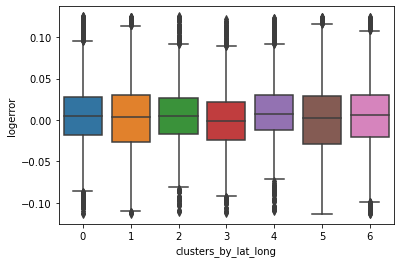

In [84]:
sns.boxplot(data=train_scaled,x='clusters_by_lat_long',y='logerror')

In [89]:
train_scaled.groupby('clusters_by_lat_long').logerror.mean()

clusters_by_lat_long
0    0.004897
1    0.002859
2    0.005709
3   -0.000744
4    0.009961
5    0.000900
6    0.004875
Name: logerror, dtype: float64

In [ ]:
# # def map_clusters(train):
#     # identified counties for fips codes 
#     clusters = {0: '',
#                 1: '',
#                 2: '',
#                 3: '',
#                 4: '',
#                 5: '',
#                 6: ''}
#     # map counties to fips codes
#     df.clusters_unscaled = df.clusters_unscaled.map(clusters)
#     return df

In [75]:
train_scaled.head(1)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror,transactiondate,propertylandusedesc,age,taxvalue_per_sqft,month_of_sale,clusters_by_lat_long,clusters_scaled
51081,1.0,0.666667,0.775477,Los_Angeles,0.58271,0.819429,0.288785,37015,96464,1.0,0.513521,8650,0.033457,2017-09-11,Single Family Residential,0.0,0.318182,1.0,1,1
